# Gender Classification of Facial Images


Gender classification of facial images is a very important topic. It can provide information on an individual's identity and background. Currently, it's used in many applications such as services in human-computer interaction, visual surveillance, security, and intelligent advertising.

In this notebook, I will be building a convolutional neural network (CNN) in order to classify images from a dataset as either being of a man or woman.

This notebook is based off of a Kaggle notebook [here](https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn/?select=age_gender.csv).

## Overview of Data

This data can be found on Kaggle [here](https://www.kaggle.com/thanaphatj/gender-classification-of-facial-images-cnn/?select=age_gender.csv). It includes information on:

- age (from 1 to 116)
- ethnicity (0: white, 1: Black, 2: Asian, 3: Indian, 4: other)
- gender (0: man, 1: woman)
- image name
- pixel data


## Data Exploration

We can begin by loading in the CSV file and doing some initial data exploration. This will help guide our preprocessing as well. 

In [192]:
import os # accessing directory structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set Seed
np.random.seed(11)
set_seed(11)
random.seed(11)

In [202]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data = pd.read_csv("/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
data.info()

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [194]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


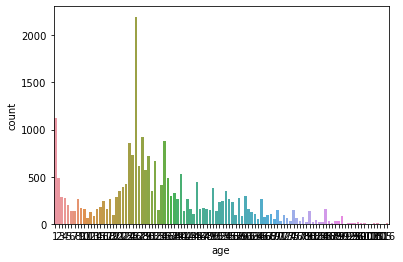

In [195]:
sns.countplot(x='age', data=data) #age distribution

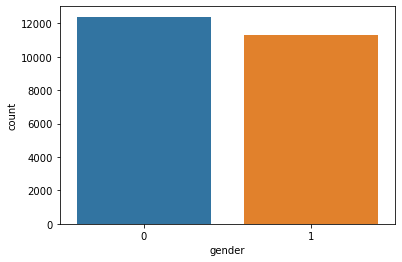

In [196]:
sns.countplot(x='gender', data=data) #gender distribution

## Data Preprocessing

In data preprocessing, we prepare the data to be fed into a machine or deep learning model. In our preprocessing, we'll do a few things:

- Select only data with people who are adults
  - We see the data is heavily representing younger people, which might skew our model. Thus, we'll only select adults to create a more equal distribution.

- Format width and height of pixel data

- Splitting into `X` and `y`

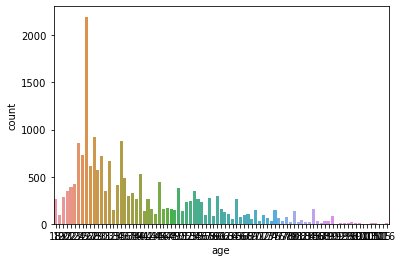

In [203]:
# select adults
data = data[data['age'] >= 18]
sns.countplot(x='age', data=data) #age distribution

We now find that the age distribution is more even.

In [204]:
data.reset_index(drop=True, inplace=True)
data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [205]:
data.isnull().sum() # Check null data

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

We don't appear to have any null values. If we did, we'd have to explore options such as removal or imputing.

In [206]:
# Input image configuration
num_pixels = len(data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [207]:
# Splitting dataset into X and y
X_img = data.iloc[:,4].copy()
y_age = data.iloc[:,0].copy()
y_ethnicity = data.iloc[:,1].copy()
y_gender = data.iloc[:,2].copy()

# splitting the data into train and te sets.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
# splitting 'te' set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    '''
    Function to convert pixel data (string) into numpy_array of pixels
    '''
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [208]:
target_columns = ['gender', 'ethnicity', 'age']

data_preprocess = data.drop('img_name', axis=1)
y = data_preprocess[target_columns]
X = data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [209]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ]) # channel is 1

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


Before we move onto data visualization, we'll convert the other `y`'s to numpy arrays.

In [211]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

# **Data Visualization**

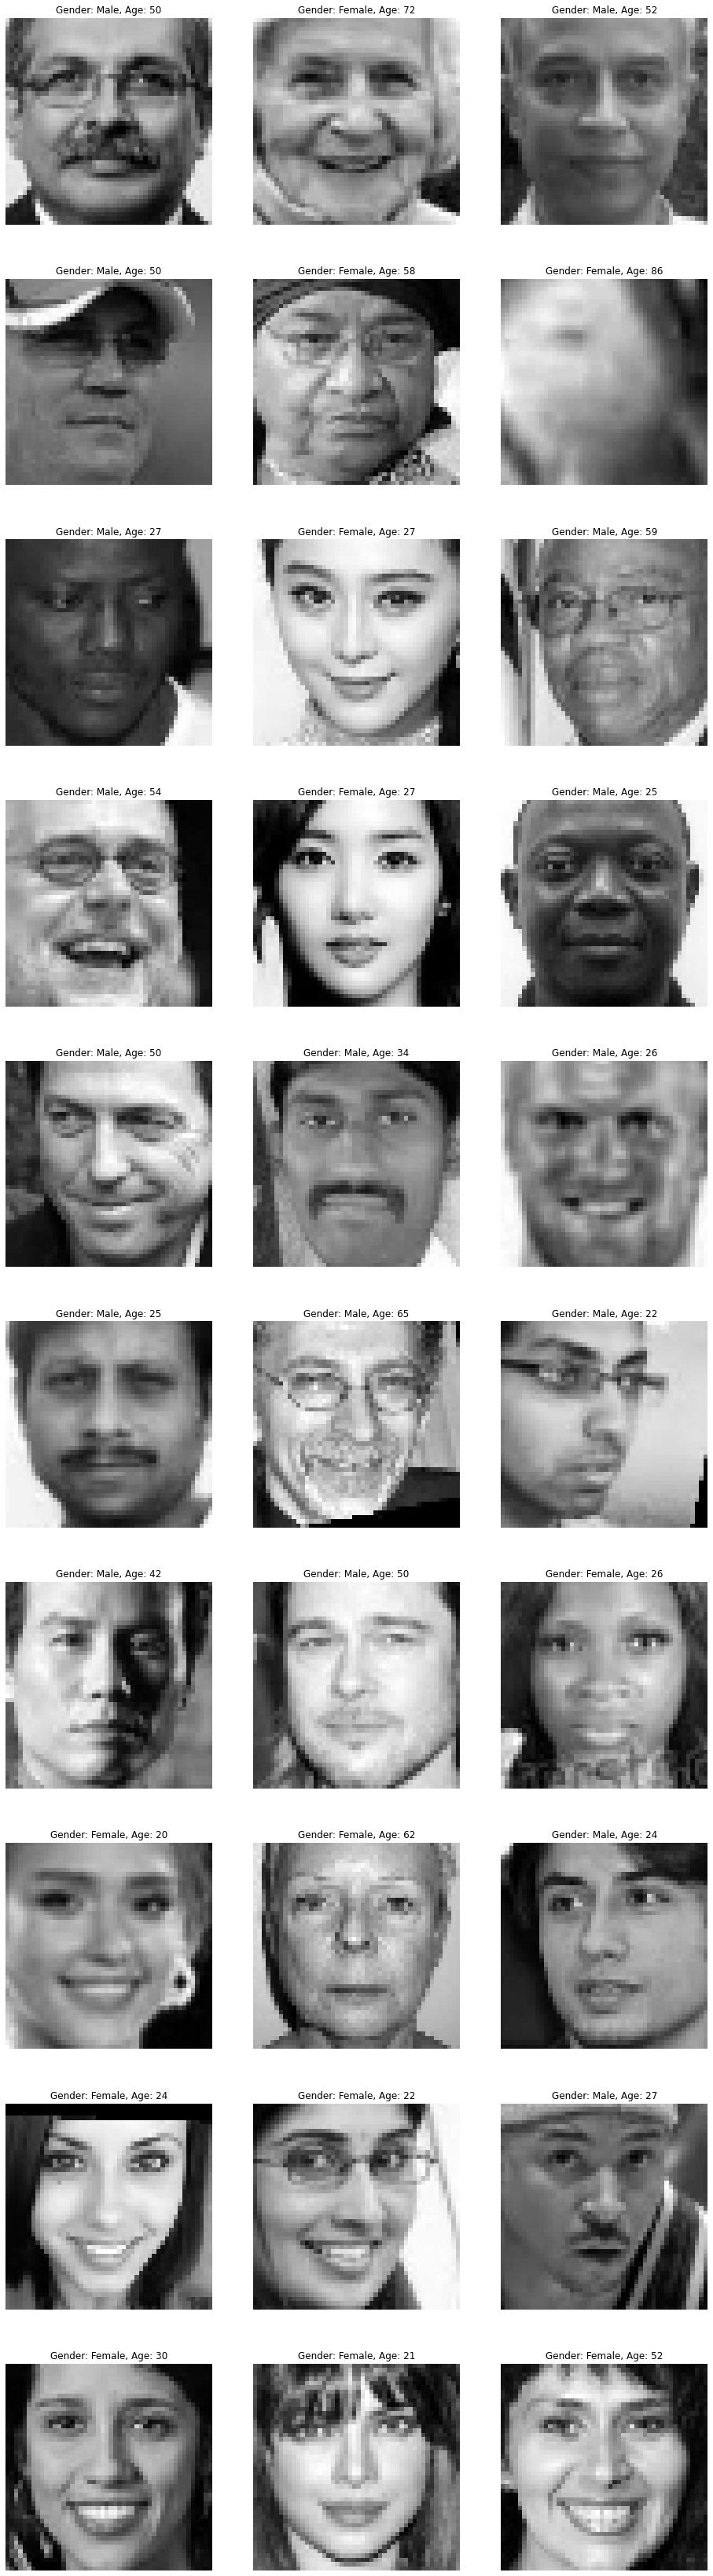

In [212]:
rows = 10 # rows in subplots
cols = 3 # columns in subplots
samp = random.sample(range(X.shape[0]),rows*cols) #selecting 100 random samples
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   

for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

# **Image Augmentation**

**Data augmentation**: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation.
This code below shows 100 samples of Data augmentation. I've changed the values below to allow for a bit more variation within the `ImageDataGenerator`.

In [214]:
train_data_gen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=1,
                                    brightness_range=[0.7,1.3],
                                    zoom_range=[0.7,1.3],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [216]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

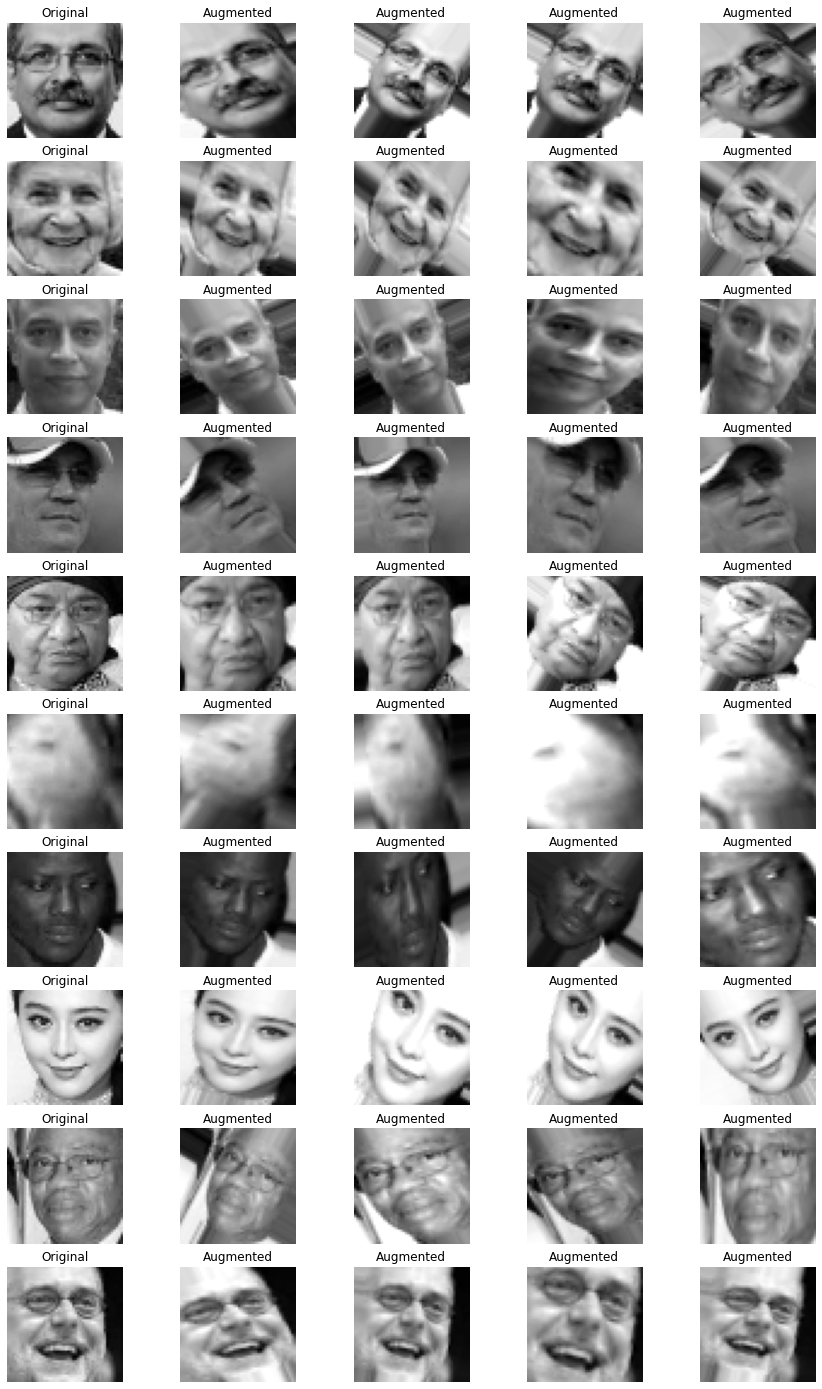

In [217]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

# **Training the Model**

In the model, we'll use a batch size of 32 and 30 epochs. We'll also use `Adam` as our optimizer and `ReLU` as our activation function. We'll be doing k-fold cross validation, but I've changed k to equal 8.

In [232]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 30
optimizer = Adam()
verbosity = 1
num_folds = 8
activation='softmax' 

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [229]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [230]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
    
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
533/533 [==============================] - 14s 26ms/step - loss: 0.7786 - accuracy: 0.6605 - val_loss: 0.6339 - val_accuracy: 0.6282
Epoch 2/30
533/533 [==============================] - 13s 24ms/step - loss: 0.4907 - accuracy: 0.7669 - val_loss: 0.4376 - val_accuracy: 0.8077
Epoch 3/30
533/533 [==============================] - 13s 24ms/step - loss: 0.4082 - accuracy: 0.8189 - val_loss: 0.4015 - val_accuracy: 0.8365
Epoch 4/30
533/533 [==============================] - 13s 25ms/step - loss: 0.3756 - accuracy: 0.8407 - val_loss: 0.3725 - val_accuracy: 0.8406
Epoch 5/30
533/533 [==============================] - 13s 24ms/step - loss: 0.3624 - accuracy: 0.8438 - val_loss: 0.3423 - val_accuracy: 0.8463
Epoch 6/30
533/533 [==============================] - 14s 26ms/step - loss: 0.3494 - accuracy: 0.8505 - val_loss: 0.3112 - val_accuracy: 0.8833
Epoch 7/30
533/533 [===================

Score for fold 1: loss of 0.28891611099243164; accuracy of 88.04436922073364%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/30
533/533 [==============================] - 13s 25ms/step - loss: 0.6862 - accuracy: 0.6317 - val_loss: 0.6112 - val_accuracy: 0.6684
Epoch 2/30
533/533 [==============================] - 13s 24ms/step - loss: 0.5490 - accuracy: 0.7314 - val_loss: 0.4981 - val_accuracy: 0.7646
Epoch 3/30
533/533 [==============================] - 14s 26ms/step - loss: 0.4517 - accuracy: 0.7975 - val_loss: 0.3606 - val_accuracy: 0.8492
Epoch 4/30
533/533 [==============================] - 14s 26ms/step - loss: 0.4115 - accuracy: 0.8171 - val_loss: 0.4436 - val_accuracy: 0.7769
Epoch 5/30
533/533 [==============================] - 14s 26ms/step - loss: 0.3748 - accuracy: 0.8375 - val_loss: 0.5149 - val_accuracy: 0.7432
Epoch 6/30
533/533 [==============================] - 13s 25ms/step - loss: 0.3561 - accuracy: 0.8487 - v

Score for fold 2: loss of 0.2592938542366028; accuracy of 89.68775868415833%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/30
533/533 [==============================] - 14s 27ms/step - loss: 0.6541 - accuracy: 0.6689 - val_loss: 0.7094 - val_accuracy: 0.5349
Epoch 2/30
533/533 [==============================] - 13s 25ms/step - loss: 0.5167 - accuracy: 0.7536 - val_loss: 0.6130 - val_accuracy: 0.6553
Epoch 3/30
533/533 [==============================] - 14s 26ms/step - loss: 0.4442 - accuracy: 0.8038 - val_loss: 0.3975 - val_accuracy: 0.8147
Epoch 4/30
533/533 [==============================] - 13s 25ms/step - loss: 0.4033 - accuracy: 0.8247 - val_loss: 0.3881 - val_accuracy: 0.8262
Epoch 5/30
533/533 [==============================] - 13s 25ms/step - loss: 0.3789 - accuracy: 0.8367 - val_loss: 0.4019 - val_accuracy: 0.8081
Epoch 6/30
533/533 [==============================] - 14s 26ms/step - loss: 0.3567 - accuracy: 0.8479 - va

KeyboardInterrupt: 

In [231]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.28891611099243164 - Accuracy: 88.04436922073364%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2592938542366028 - Accuracy: 89.68775868415833%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 88.86606395244598 (+- 0.8216947317123413)
> Loss: 0.2741049826145172
------------------------------------------------------------------------


In [233]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)
  
model = Sequential()
  
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [234]:
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=20, validation_data=val_data)

Epoch 1/20
609/609 [==============================] - 14s 24ms/step - loss: 0.7479 - accuracy: 0.6668 - val_loss: 0.7997 - val_accuracy: 0.5505
Epoch 2/20
609/609 [==============================] - 14s 24ms/step - loss: 0.4650 - accuracy: 0.7843 - val_loss: 0.4070 - val_accuracy: 0.8038
Epoch 3/20
609/609 [==============================] - 15s 24ms/step - loss: 0.3932 - accuracy: 0.8288 - val_loss: 0.3196 - val_accuracy: 0.8721
Epoch 4/20
609/609 [==============================] - 14s 24ms/step - loss: 0.3630 - accuracy: 0.8419 - val_loss: 0.3678 - val_accuracy: 0.8423
Epoch 5/20
609/609 [==============================] - 14s 23ms/step - loss: 0.3481 - accuracy: 0.8527 - val_loss: 0.2497 - val_accuracy: 0.9041
Epoch 6/20
609/609 [==============================] - 15s 25ms/step - loss: 0.3358 - accuracy: 0.8594 - val_loss: 0.2493 - val_accuracy: 0.9082
Epoch 7/20
609/609 [==============================] - 14s 23ms/step - loss: 0.3263 - accuracy: 0.8607 - val_loss: 0.2388 - val_accuracy:

In [235]:
# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'val_loss'}, 
title='Training History')
fig.show()


# Generate generalization metrics
fig = px.line(
final_model_history.history, y=['accuracy', 'val_accuracy'],
labels={'index': 'epoch', 'value': 'accuracy'}, 
title='Training History')
fig.show()

In [236]:
model.save("backup")

In [237]:
# Metrics
model.evaluate(test_data)

28/28 [==============================] - 0s 6ms/step - loss: 0.1601 - accuracy: 0.9430


[0.16010944545269012, 0.9429874420166016]

In [239]:
y_pred = model.predict_classes(test_data)

In [240]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       468
           1       0.94      0.93      0.94       409

    accuracy                           0.94       877
   macro avg       0.94      0.94      0.94       877
weighted avg       0.94      0.94      0.94       877



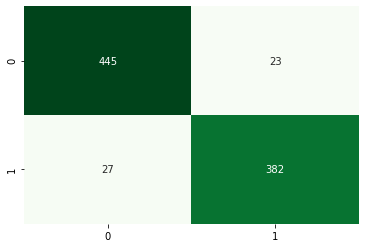

In [241]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

# **Error Analysis**

In [243]:
error_index = (y_test != y_pred)#finding error indices
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

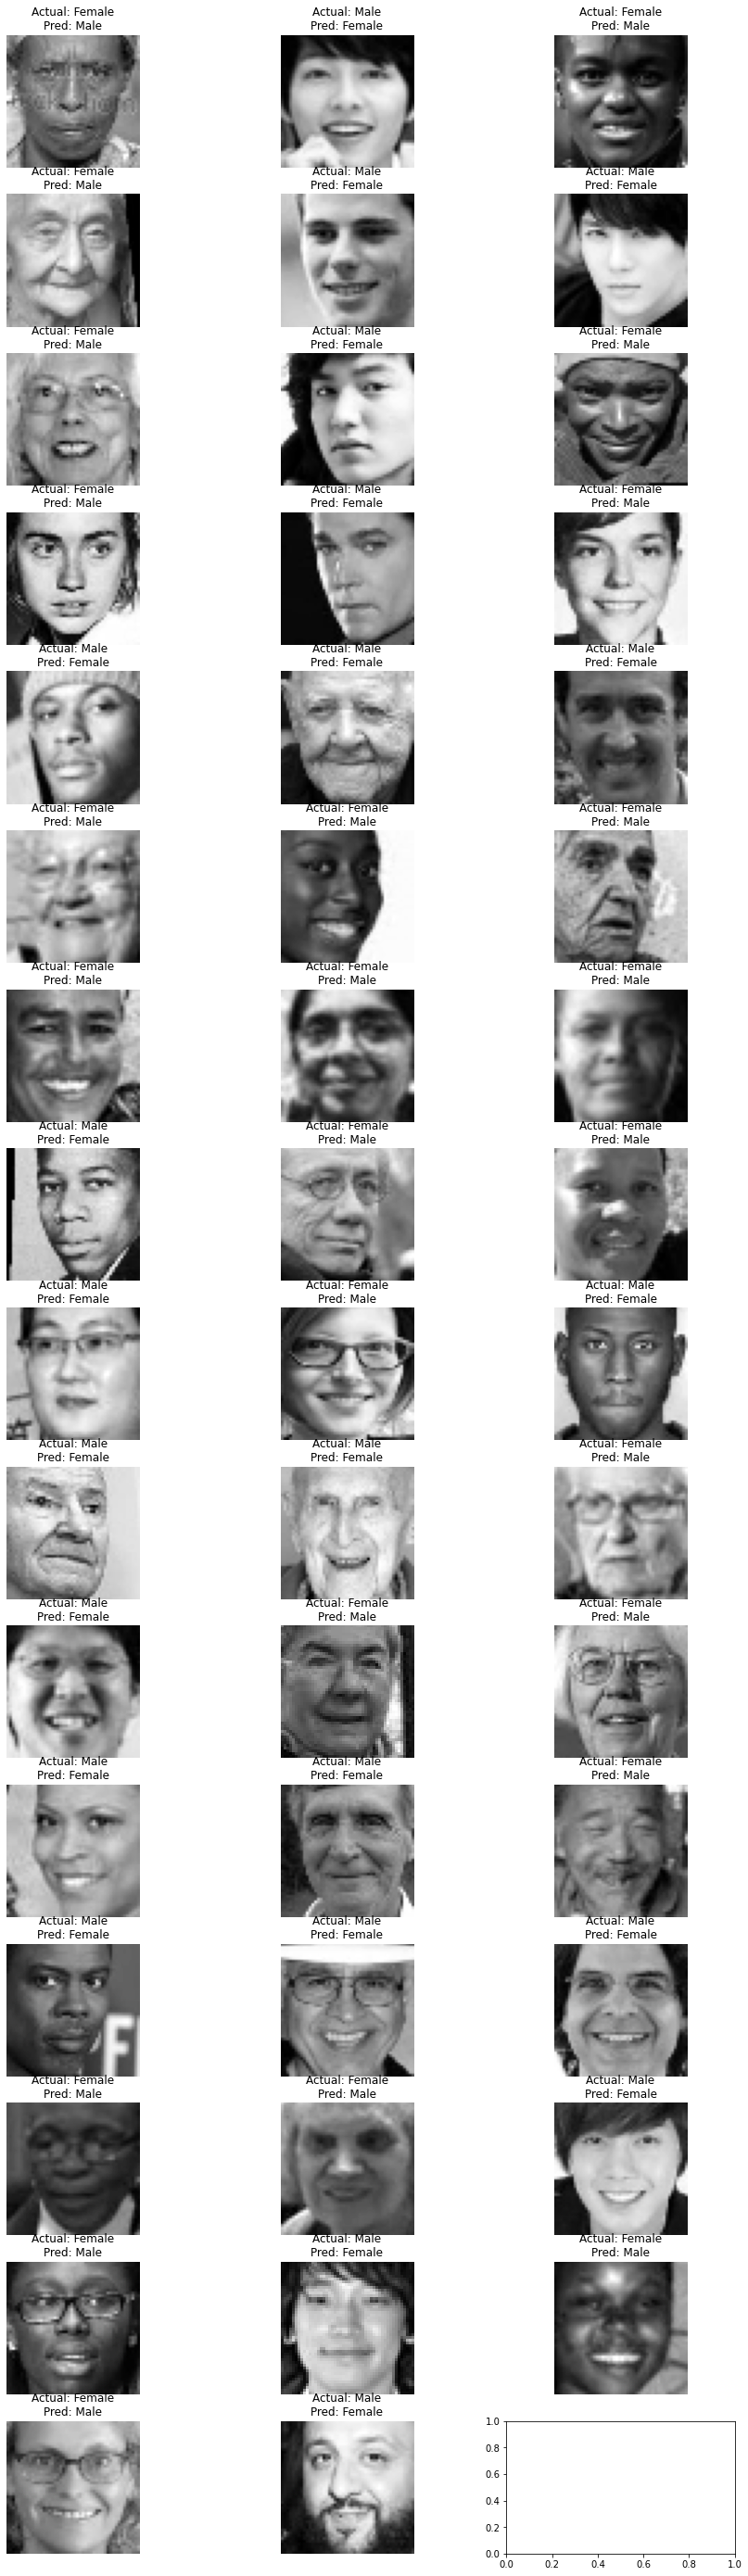

In [244]:
rows=int(np.floor(sum(error_index)/3)) #rows in subplots
cols=3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()

We see that a lot of the errors are in incorrectly classifying people of color. This could be a symptom of bias in AI and how algorithms can often be developed without minorities in mind.